# Backgrond
- Structural Model: One Compartment Linear Elimination
- Route of Administration: IV Bolus
- Dosage Regimen: 10 mg IV

# Libraries

In [1]:
import jax
import jax.numpy as np
from jax import random
from jax.experimental.ode import odeint

import numpyro 
import numpyro.distributions as dist 
from numpyro.infer import MCMC, NUTS, SVI, Trace_ELBO
from numpyro.infer.initialization import init_to_median
from numpyro.infer.autoguide import AutoNormal
from numpyro.optim import Adam

import arviz as az
import matplotlib.pyplot as plt

/Users/peng/miniforge3/envs/numpyro/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Model

In [2]:
def PK01_ODE(INIT, TIME, VC, CL):
    # Initial amount in central compartment (mg)
    A0 = INIT
    # Amount change in central compartment (mg)
    DA_DT = - CL / VC * A0
    return DA_DT

# Simulation

TRUE ETA 
[-0.5491717 -0.5408389]
INDIVIDUAL CL 
[0.13730077 0.10243063 0.24189623 0.08327333 0.21556628]
INDIVIDUAL VC 
[10.265236  12.853039   9.503054   8.0136795  6.5710444]


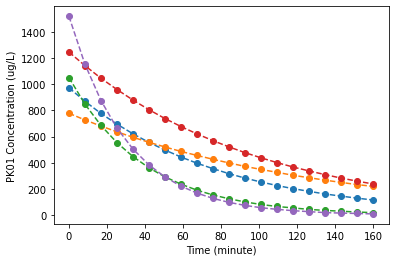

In [22]:
N = 5
TVCL = np.array([0.2])         # L/hr
TVVC = np.array([10.])        # L
SIGMA = np.array([0.5])
TIME = np.linspace(0, 160, 20) # min
INIT = np.array([10.] * N)     # mg

ODEINT_VMAP = jax.vmap(odeint, in_axes=(None, 0, None, 0, 0)) # in_axes: ODEfunc, INIT, TIME, VC, CL

with numpyro.handlers.seed(rng_seed=1234):
    # Between-Subject Variance
    ETA = numpyro.sample("ETA", dist.MultivariateNormal(covariance_matrix=np.diag(np.array([0.1, 0.1]))))
    print(f"TRUE ETA \n{ETA}")
    # CL = TVCL * exp(ETA_CL)
    CL =  numpyro.sample("CL",  dist.LogNormal(loc=np.log(TVCL), scale=ETA[0]).expand([N,]))
    print(f"INDIVIDUAL CL \n{CL}")
    # VC = TVVC * exp(ETA_VC)
    VC =  numpyro.sample("VC",  dist.LogNormal(loc=np.log(TVVC), scale=ETA[1]).expand([N,]))
    print(f"INDIVIDUAL VC \n{VC}")
    # Amount in Central Compartment
    A0 = ODEINT_VMAP(PK01_ODE, INIT, TIME, VC, CL)
    # Concentration (ug/L)
    A0_VC = jax.vmap(lambda c, v: c/v * 1000, in_axes=(0, 0))(A0, VC)
    # ADD Within-Subject Variance
    DV = numpyro.sample("DV", dist.Normal(loc=A0_VC, scale=SIGMA))

for i in range(N):
    plt.plot(TIME, DV[i], "o--")
    plt.xlabel("Time (minute)")
    plt.ylabel("PK01 Concentration (ug/L)")

# Regression

## MCMC

In [13]:

def PK01_MODEL(INIT, TIME, N, OBS=None):
    # PRIORS
    # THETA (TIPICAL VALUES)
    TVCL = numpyro.sample("TVCL", dist.Uniform(0, 1))
    TVVC = numpyro.sample("TVVC", dist.Uniform(0, 15))
    # ETA
    ETA  = numpyro.sample("ETA",  dist.MultivariateNormal(covariance_matrix=np.diag(np.array([0.1, 0.1]))))
    # THETA * EXP(ETA)
    CL  = numpyro.sample("CL", dist.LogNormal(loc=np.log(TVCL), scale=ETA[0]).expand([N,]))
    VC  = numpyro.sample("VC", dist.LogNormal(loc=np.log(TVVC), scale=ETA[1]).expand([N,]))
    # SIGMA
    SIGMA = numpyro.sample("SIGMA", dist.HalfNormal())
    
    # LIKELIHOOD
    A0 = ODEINT_VMAP(PK01_ODE, INIT, TIME, VC, CL)
    A0_VC = jax.vmap(lambda c, v: c/v * 1000, in_axes=(0, 0))(A0, VC)
    numpyro.sample("DV", dist.Normal(loc=A0_VC, scale=SIGMA), obs=OBS)


In [19]:
kernel = NUTS(PK01_MODEL, init_strategy=init_to_median())
mcmc = MCMC(kernel, num_chains=3, num_warmup=500, num_samples=1500)
mcmc.run(random.PRNGKey(123), INIT, TIME, N, OBS=DV)

/var/folders/cb/pxnfxyts32n8rdq49q4djgs80000gn/T/ipykernel_86818/4123535426.py:2: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_chains=3, num_warmup=500, num_samples=1500)
sample: 100%|██████████| 2000/2000 [00:18<00:00, 105.95it/s, 31 steps of size 3.67e-02. acc. prob=0.90] 


In [21]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     CL[0]      0.14      0.00      0.14      0.14      0.14   5536.00      1.00
     CL[1]      0.10      0.00      0.10      0.10      0.10   4590.08      1.00
     CL[2]      0.24      0.00      0.24      0.24      0.24   5065.12      1.00
     CL[3]      0.08      0.00      0.08      0.08      0.08   5518.29      1.00
     CL[4]      0.22      0.00      0.22      0.22      0.22   5754.56      1.00
    ETA[0]      0.45      0.12      0.43      0.27      0.63   1351.96      1.00
    ETA[1]      0.30      0.11      0.28      0.15      0.45    849.16      1.00
     SIGMA      0.45      0.04      0.45      0.39      0.51   1113.05      1.00
      TVCL      0.15      0.03      0.15      0.10      0.21   1153.30      1.00
      TVVC      9.42      1.25      9.34      7.38     11.46    770.97      1.00
     VC[0]     10.27      0.00     10.27     10.26     10.27   5723.83      1.00
     VC[1]     12.85      0

## SVI

100%|██████████| 2000/2000 [00:03<00:00, 528.32it/s, init loss: 21217513472.0000, avg. loss [1901-2000]: 42849.8242]  


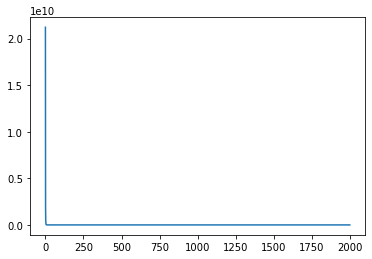

In [72]:
# approximation
# guide = AutoLaplaceApproximation(PK01_MODEL,hessian_fn=lambda f, x: jax.jacobian(jax.jacobian(f))(x))
guide = AutoNormal(PK01_MODEL)
svi   = SVI(PK01_MODEL, guide, Adam(0.5), Trace_ELBO())
svi_result = svi.run(random.PRNGKey(1122), INIT=INIT, TIME=TIME, N=N, OBS=DV, num_steps=2000)
plt.plot(svi_result.losses)

100%|██████████| 2000/2000 [00:03<00:00, 516.73it/s, init loss: 35547.4766, avg. loss [1901-2000]: 1659.0146] 


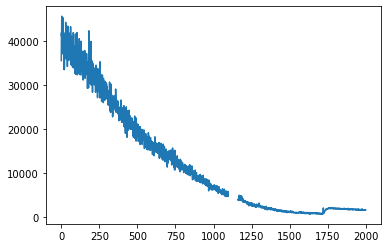

In [73]:
svi_result = svi.run(random.PRNGKey(123), INIT=INIT, TIME=TIME, N=N, OBS=DV, num_steps=2000, init_state=svi_result.state)
plt.plot(svi_result.losses)

100%|██████████| 2000/2000 [00:03<00:00, 523.75it/s, init loss: 1549.9739, avg. loss [1901-2000]: 457.5564] 


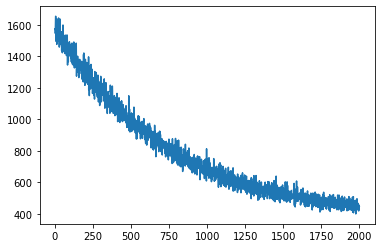

In [74]:
svi_result = svi.run(random.PRNGKey(1122), INIT=INIT, TIME=TIME, N=N, OBS=DV, num_steps=2000, init_state=svi_result.state)
plt.plot(svi_result.losses)

In [75]:
# summary of approximation
samples = guide.sample_posterior(random.PRNGKey(123), svi_result.params, (1000,))
numpyro.diagnostics.print_summary(samples, prob=0.89, group_by_chain=False)

# TROUBLE SHOOTING: https://github.com/pyro-ppl/numpyro/issues/1309


                mean       std    median      5.5%     94.5%     n_eff     r_hat
     CL[0]      0.14      0.00      0.14      0.14      0.14   1007.65      1.00
     CL[1]      0.10      0.00      0.10      0.10      0.10    936.80      1.00
     CL[2]      0.24      0.00      0.24      0.24      0.24    929.40      1.00
     CL[3]      0.08      0.00      0.08      0.08      0.08    947.88      1.00
     CL[4]      0.21      0.00      0.21      0.21      0.22    774.57      1.00
    ETA[0]      0.49      0.00      0.49      0.49      0.49    958.03      1.00
    ETA[1]      0.85      0.00      0.85      0.85      0.85      0.50      1.00
     SIGMA      6.24      0.20      6.25      5.95      6.57   1037.34      1.00
      TVCL      0.15      0.01      0.15      0.14      0.17    989.08      1.00
      TVVC      9.14      3.69      9.71      3.15     14.28   1013.90      1.00
     VC[0]      9.81      0.07      9.80      9.70      9.92    990.54      1.00
     VC[1]     12.85      0